In [1]:
print("Hello world")

Hello world


In [2]:
!pip install colorama

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style
import xgboost
import catboost 
import lightgbm

from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, SplineTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error



In [4]:
# configuration
COMPUTE_TEST_PRED=True
USE_ORIGINAL_DATA=True

# containers for results
oof,test_pred={},{}


## Reading Data

In [5]:
train=pd.read_csv("train.csv",index_col="id")
test=pd.read_csv("test.csv",index_col='id')

train['Sex']=train['Sex'].astype('category')
test['Sex']=test['Sex'].astype(train['Sex'].dtype)

In [6]:
if not train.isna().any().any():
    print(f"There are no missing values in train, train-size:{train.shape}")

if not test.isna().any().any():
    print(f"There are no missing values in test, test-size:{test.shape}")

There are no missing values in train, train-size:(90615, 9)
There are no missing values in test, test-size:(60411, 8)


In [7]:
numeric_features=['Length', 'Diameter', 'Height', 'Whole weight', 
                  'Whole weight.1', 'Whole weight.2', 'Shell weight']
numeric_vars=numeric_features+['Rings']

In [8]:
train.head(15).T

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Sex,F,F,I,M,I,F,M,F,I,I,M,M,F,I,I
Length,0.55,0.63,0.16,0.595,0.555,0.61,0.415,0.61,0.205,0.565,0.485,0.605,0.595,0.44,0.555
Diameter,0.43,0.49,0.11,0.475,0.425,0.48,0.325,0.49,0.15,0.425,0.39,0.5,0.475,0.345,0.435
Height,0.15,0.145,0.025,0.15,0.13,0.17,0.11,0.15,0.04,0.125,0.135,0.185,0.145,0.11,0.145
Whole weight,0.7715,1.13,0.021,0.9145,0.782,1.201,0.3315,1.1165,0.046,0.651,0.6335,1.218,0.9085,0.4495,0.7905
Whole weight.1,0.3285,0.458,0.0055,0.3755,0.3695,0.5335,0.1655,0.4955,0.0145,0.3795,0.3035,0.5885,0.3605,0.175,0.3495
Whole weight.2,0.1465,0.2765,0.003,0.2055,0.16,0.3135,0.0715,0.2945,0.0105,0.142,0.165,0.2705,0.1765,0.0945,0.1815
Shell weight,0.24,0.32,0.005,0.25,0.1975,0.3085,0.13,0.295,0.01,0.18,0.2,0.31,0.265,0.1365,0.2425
Rings,11,11,6,10,9,10,9,9,4,8,8,11,15,7,10


### Insights  
* The Target variable `Rings` is Integer. we can use it with `StratifiedKFold`. The stratification gives better CV-LB score than a simple Kfold.  
* With 90000> samples, training dataset is too big for kernelbased regressors (eg:`SVR`,`KernelRidge`,`GaussianProcessRegressor`).   
* `Sex` is a categorical variable. For some models we will need it to be one hot encoded, for other models, it is suffices to mark as categorical. 


In [9]:
!pip install ucimlrepo

In [10]:
if USE_ORIGINAL_DATA:
    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    abalone=fetch_ucirepo(id=1)

    # make the dataframe
    original_dataset=pd.concat([abalone['data']['features'],
                                abalone['data']['targets']],axis=1).rename(
                                    {
                                    "Whole_weight":"Whole weight",
                                    "Shucked_weight":"Whole weight.1",
                                    "Viscera_weight":"Whole weight.2",
                                    "Shell_weight":"Shell weight"
                                },axis=1)

    original_dataset["Sex"]=original_dataset["Sex"].astype(train["Sex"].dtype)
    print(f"Original Dataset Shape: {original_dataset.shape}")

Original Dataset Shape: (4177, 9)


## Correlation

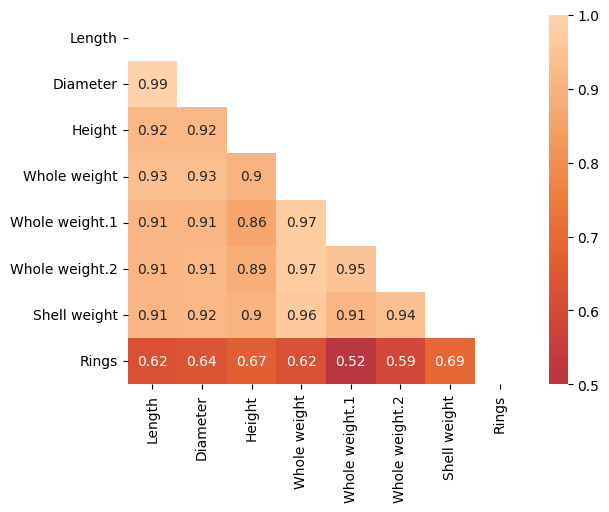

In [11]:
cc=np.corrcoef(train[numeric_vars],rowvar=False)
sns.heatmap(cc,
            center=0,
            cmap=sns.color_palette("icefire", as_cmap=True),
            annot=True,
            xticklabels=numeric_vars,
            yticklabels=numeric_vars,
            mask=np.triu(cc),
            vmax=1,
            vmin=0.5)
plt.show()

### Insights  
* All features are important

## Target Distribution

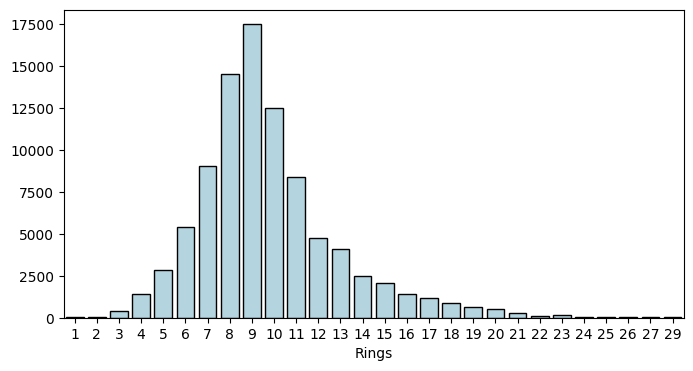

In [12]:
vc=train['Rings'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(data=pd.DataFrame(vc),x=vc.index,y=vc.values,color='lightblue',edgecolor='black')
plt.show()


### Insights  
* Since all training targets are between 1 and 29, we may clip all predictions to the interval [1,29]

## Feature Engineering

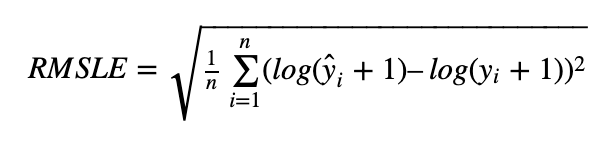

All our models will predict logarithm of the target. In this case some models will perform better if we feed the models with logarithmic features

In [13]:
log_features=[]
for col in numeric_features:
    train[f"log_{col}"]=np.log1p(train[col])
    test[f"log_{col}"]=np.log1p(test[col])

    if USE_ORIGINAL_DATA:
        original_dataset[f"log_{col}"]=np.log1p(original_dataset[col])
    log_features.append(f"log_{col}")

## Cross validation

In [14]:
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

def cross_validate(model,label,features=test.columns,n_repeats=1):
    """
    Computes OOF prediction for a given model

    OOF and test predictions are stored in the global variables oof and test_pred

    if n_repeats>1, the model is trained with different seeds

    All predictions are clipped to [1,29]
    """

    scores=[]
    oof_preds=np.full_like(train["Rings"],np.nan,dtype=float)
    for fold,(idx_train,idx_val) in enumerate(kf.split(train,train["Rings"])):
        X_train=train.iloc[idx_train][features]
        X_val=train.iloc[idx_val][features]
        y_train=train.iloc[idx_train]["Rings"]
        y_val=train.iloc[idx_val]["Rings"]

        if USE_ORIGINAL_DATA:
            X_train=pd.concat([X_train,original_dataset[features]],axis=0)
            y_train=pd.concat([y_train,original_dataset["Rings"]],axis=0)

            y_pred=np.zeros_like(y_val,dtype=float)

            for i in range(n_repeats):
                m=clone(model)
                if n_repeats>1:
                    mm=m
                    if isinstance(mm,Pipeline):
                        mm=mm[-1]
                    if isinstance(mm,TransformedTargetRegressor):
                        mm=mm.regressor

                    mm.set_params(random_state=i)
                m.fit(X_train,y_train)
                y_pred+=m.predict(X_val)
            y_pred/=n_repeats
            y_pred=y_pred.clip(1,29)

        score=mean_squared_log_error(y_val,y_pred,squared=False)
        print(f"# Fold {fold}: RMSE {score:.5f}")
        scores.append(score)
        oof_preds[idx_val]=y_pred

    print(f"{Fore.GREEN} Overall: {np.array(scores).mean():.5f} {label}{Style.RESET_ALL}")
    oof[label]=oof_preds


## Models

As the competition requires us to optimize the `mean squared log error`, we use `TransformedTargetRegressor`. If a raw model use `mean squared error`, its `TransformedTargetRegressor` will optimized the `mean squared log error`.  

We start with linear models. The linear models improve if we add non linear features with either `PolynomialFeatures` or `Nystroem`.

**Special args**:   
* remainder='passthrough': columns not specified in the transformer will be passthrough
* drop first=True: drop first category of the avoid the dummy variable trap
* PolynomialFeatures: Generate polynomial and interation features
* TransformedTargetRegressor: regression model that apply transformation to the target variable before fit the model and apply inverse transformation to predictions

In [15]:
# Polynomial features +ridge
model=make_pipeline(

    ColumnTransformer([('ohe',OneHotEncoder(drop='first'),['Sex'])],remainder='passthrough'), # transform "Sex" column to 3-1=2 Columns
    StandardScaler(),
    PolynomialFeatures(degree=3),
    TransformedTargetRegressor(Ridge(100),
                                func=np.log1p,
                                inverse_func=np.expm1))

cross_validate(model,"Poly-Ridge",numeric_features+log_features+["Sex"],n_repeats=1)

# Fold 0: RMSE 0.15298
# Fold 1: RMSE 0.15294
# Fold 2: RMSE 0.15308
# Fold 3: RMSE 0.15372
# Fold 4: RMSE 0.15158
 Overall: 0.15286 Poly-Ridge



 Overall: 0.15286 Poly-Ridge

In [16]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge(alpha=100)))])

In [17]:
# Nystreom transformer + Ridge
model=make_pipeline(

    ColumnTransformer([('ohe',OneHotEncoder(drop='first'),["Sex"])],remainder="passthrough"),
    StandardScaler(),
    Nystroem(n_components=500),
    TransformedTargetRegressor(Ridge(0.1),
                               func=np.log1p,
                               inverse_func=np.expm1))

cross_validate(model,"Nystroem-Ridge",numeric_features+log_features+["Sex"])


# Fold 0: RMSE 0.15128
# Fold 1: RMSE 0.15209
# Fold 2: RMSE 0.15185
# Fold 3: RMSE 0.15252
# Fold 4: RMSE 0.15019
 Overall: 0.15159 Nystroem-Ridge


In [21]:
# K nearest neighbours
model=make_pipeline(

    ColumnTransformer([('ohe',OneHotEncoder(drop="first"),['Sex'])],remainder="passthrough"),
    StandardScaler(),
    TransformedTargetRegressor(KNeighborsRegressor(n_neighbors=50),func=np.log1p,inverse_func=np.expm1)

    )

cross_validate(model,"KNN",log_features+["Sex"])
 

# Fold 0: RMSE 0.15433
# Fold 1: RMSE 0.15536
# Fold 2: RMSE 0.15465
# Fold 3: RMSE 0.15530
# Fold 4: RMSE 0.15324
 Overall: 0.15458 KNN


In [23]:
# random forest
model=make_pipeline(

    ColumnTransformer([('ohe',OneHotEncoder(drop='first'),['Sex'])],remainder="passthrough"),
    TransformedTargetRegressor(RandomForestRegressor(n_estimators=200,min_samples_leaf=8,max_features=5),
                               func=np.log1p,
                               inverse_func=np.expm1)
)

cross_validate(model,"Random forest",log_features+["Sex"])

# Fold 0: RMSE 0.14914
# Fold 1: RMSE 0.15017
# Fold 2: RMSE 0.15027
# Fold 3: RMSE 0.15016
# Fold 4: RMSE 0.14814
 Overall: 0.14958 Random forest


In [24]:
# ExtraTreesRegressor
model=make_pipeline(

    ColumnTransformer([('ohe',OneHotEncoder(drop="first"),["Sex"])],remainder="passthrough"),
    TransformedTargetRegressor(ExtraTreesRegressor(n_estimators=200,min_samples_leaf=7),
                               func=np.log1p,
                               inverse_func=np.expm1)
)

cross_validate(model,"ExtraTrees",log_features+["Sex"])

# Fold 0: RMSE 0.15002
# Fold 1: RMSE 0.15088
# Fold 2: RMSE 0.15100
# Fold 3: RMSE 0.15120
# Fold 4: RMSE 0.14924
 Overall: 0.15047 ExtraTrees


In [26]:
# HistGradientBoostingRegressor
hgb_params={'max_iter': 300, 
            'max_leaf_nodes': 43, 
            'early_stopping': False, 
            'learning_rate': 0.08019987638525192, 
            'min_samples_leaf': 37}

model=make_pipeline(

    ColumnTransformer([('ohe',OneHotEncoder(drop="first"),["Sex"])],remainder="passthrough"),
    TransformedTargetRegressor(HistGradientBoostingRegressor(**hgb_params),
                               func=np.log1p,
                               inverse_func=np.expm1)
)

# cross_validate(model,"HGBR",numeric_features+["Sex"]) #0.14919
cross_validate(model,"HGBR",log_features+["Sex"])

# Fold 0: RMSE 0.14904
# Fold 1: RMSE 0.14937
# Fold 2: RMSE 0.15009
# Fold 3: RMSE 0.14978
# Fold 4: RMSE 0.14768
 Overall: 0.14919 HGBR
